In [1]:

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import get_scorer
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape
from keras.utils import plot_model
# from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.optimizers import Adam, RMSprop
import math
from pandas import DataFrame
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import math
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilis import get_dataset, mean_absolute_percentage_error, plot_train_history

days_ahead = 5

2023-12-12 16:33:34.348180: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 16:33:34.404853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 16:33:34.404891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 16:33:34.406486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 16:33:34.415255: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 16:33:34.416712: I tensorflow/core/platform/cpu_feature_guard.cc:1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 53, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 53, 64)            49408     
                                                                 
 dense (Dense)               (None, 53, 64)            4160      
                                                                 
 dropout (Dropout)           (None, 53, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

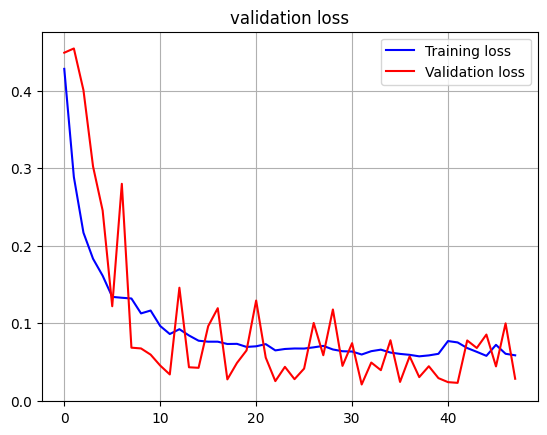

Evaluate model on test data
4/4 [==============================] - 0s 15ms/step
--------------------------------------------------------
test MAPE: 2.920058999547065 %
-------------------------------------------------------
Trend Catch Accuracy: 67.5 %


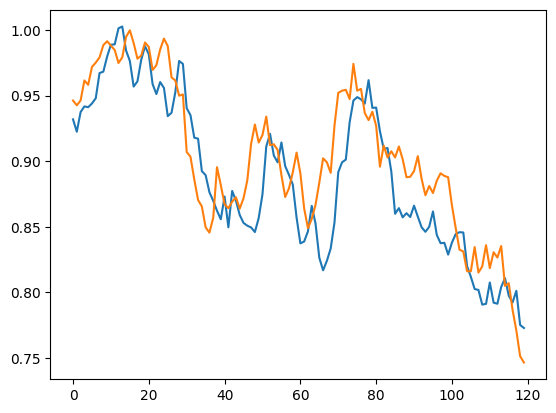

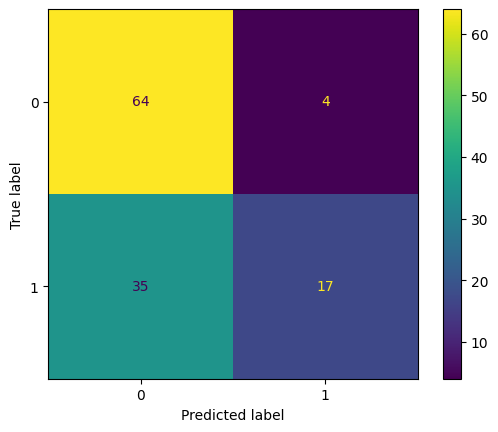

In [2]:

def run_nets(horizon, number_lags):

    read_df = get_dataset(mode='eval', horizon=horizon, number_lags=number_lags)


    # Split data into train test validation
    TRAIN_SPLIT = math.ceil(len(read_df)*0.9*0.9)
    y_train = np.stack(read_df.iloc[:TRAIN_SPLIT, 0].values)
    x_train = np.expand_dims(read_df.iloc[:TRAIN_SPLIT, 1:].values, axis=2)
    y_val = np.stack(read_df.iloc[TRAIN_SPLIT:math.ceil(TRAIN_SPLIT/0.9), 0].values)
    x_val= np.expand_dims(read_df.iloc[TRAIN_SPLIT:math.ceil(TRAIN_SPLIT/0.9), 1:].values, axis=2)
    y_test = np.stack(read_df.iloc[math.ceil(TRAIN_SPLIT/0.9):, 0].values)
    x_test = np.expand_dims(read_df.iloc[math.ceil(TRAIN_SPLIT/0.9):, 1:].values, axis=2)

    # LSTM Architecture
    BATCH_SIZE = 32 # bacth size in batch-SGD/variants
    BUFFER_SIZE = 10000 # for shuffling the dataset
    train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()# defaule is repeated till number of time batch run
    #https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat
    val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128,
                                  return_sequences=True,
                                  input_shape=x_train.shape[-2:],
                                  activation='relu'
                                  ))
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(tf.keras.layers.Dense(horizon, activation='relu'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mae')
    # Train and evaluate
    STEPS_PER_EPOCH = 10
    EPOCHS = 100
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    model.summary()
    multy_step_history = model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=10, callbacks=[callback])
    # Plot validation loss
    plot_train_history(multy_step_history, 'validation loss')
    # Calculate MAPE
    print("Evaluate model on test data")
    yhat = model.predict(x_test)
    predicted = yhat[:,-1]
    print("--------------------------------------------------------")
    print("test MAPE:", mean_absolute_percentage_error(y_test[:,-1], predicted), '%')
    print("-------------------------------------------------------")
    plt.plot(range(len(predicted)), predicted)
    plt.plot(range(len(y_test[:,-1])), y_test[:,-1])
    # Plot Accuracy
    true_trend_1 = y_test[:horizon,-1] - y_val[-horizon:,-1]
    true_trend_2 = y_test[horizon:len(y_test),-1] - y_test[:len(y_test)-horizon,-1]
    true_trend = [*true_trend_1, *true_trend_2]
    binary_true_trend = []
    for e in true_trend:
        if e > 0:
            binary_true_trend.append(1)
        else:
            binary_true_trend.append(0)


    predicted_trend_1 = yhat[:horizon,-1] - y_val[-horizon:,-1]
    predicted_trend_2= yhat[horizon:len(yhat),-1] - y_test[:len(y_test)-horizon,-1]
    predicted_trend = [*predicted_trend_1, *predicted_trend_2]

    binary_predicted_trend = []
    for e in predicted_trend:
        if e > 0:
            binary_predicted_trend.append(1)
        else:
            binary_predicted_trend.append(0)

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    print("Trend Catch Accuracy:", accuracy_score(binary_true_trend, binary_predicted_trend) * 100,'%')
    cm = confusion_matrix(binary_true_trend, binary_predicted_trend)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return model

run_nets(days_ahead, 20)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 83, 128)           66560     
                                                                 
 lstm_4 (LSTM)               (None, 83, 64)            49408     
                                                                 
 dense_3 (Dense)             (None, 83, 64)            4160      
                                                                 
 dropout_2 (Dropout)         (None, 83, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)               

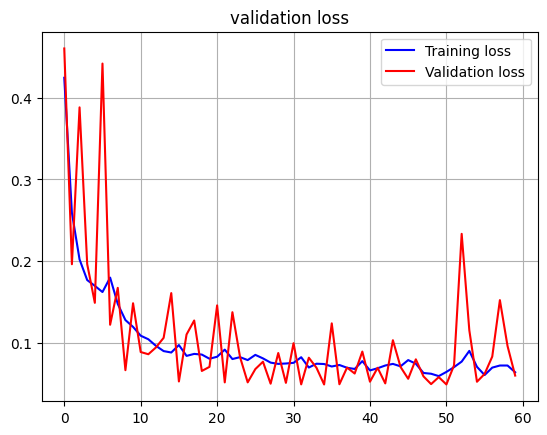

Evaluate model on test data
4/4 [==============================] - 0s 25ms/step
--------------------------------------------------------
test MAPE: 5.174922501772314 %
-------------------------------------------------------
Trend Catch Accuracy: 58.333333333333336 %


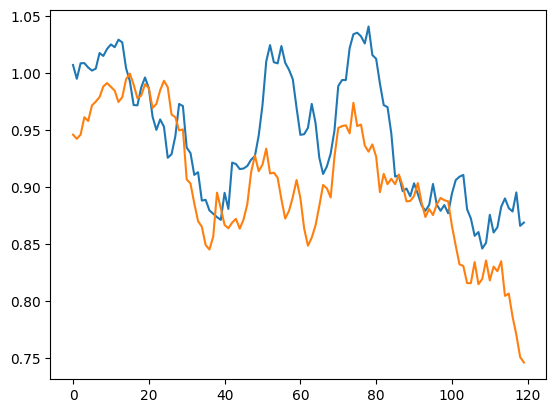

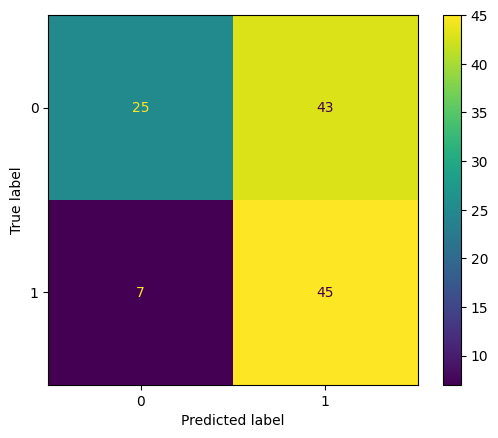

In [3]:
run_nets(days_ahead, 50)

/workspaces/OEOD-/SUP/utilis.py:215: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df[f'lag_{period}'] = read_df['close'].shift(periods = period, axis = 0)
/workspaces/OEOD-/SUP/utilis.py:225: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df['multy_close'] = multy_variate_Closing_Price
/workspaces/OEOD-/SUP/utilis.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 133, 128)          66560     
                                                                 
 lstm_7 (LSTM)               (None, 133, 64)           49408     
                                                                 
 dense_6 (Dense)             (None, 133, 64)           4160      
                                                                 
 dropout_4 (Dropout)         (None, 133, 64)           0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

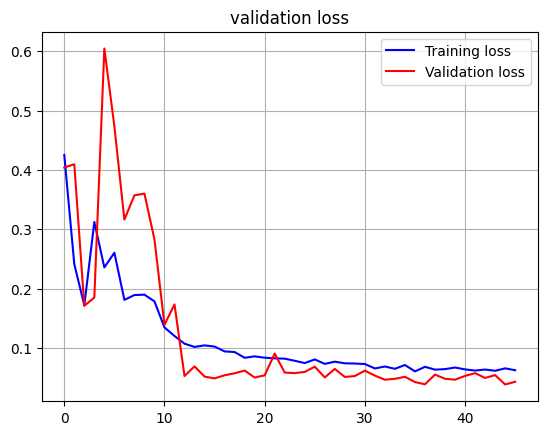

Evaluate model on test data
4/4 [==============================] - 0s 51ms/step
--------------------------------------------------------
test MAPE: 5.742869759857765 %
-------------------------------------------------------
Trend Catch Accuracy: 60.0 %


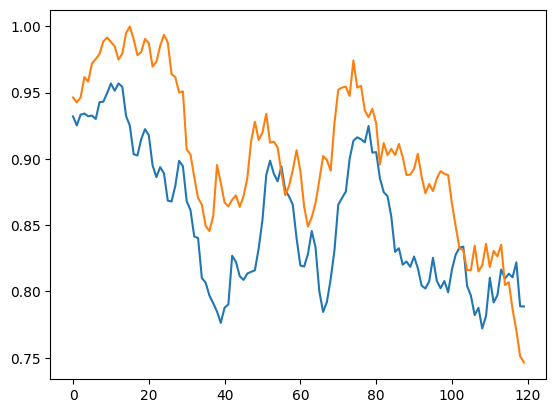

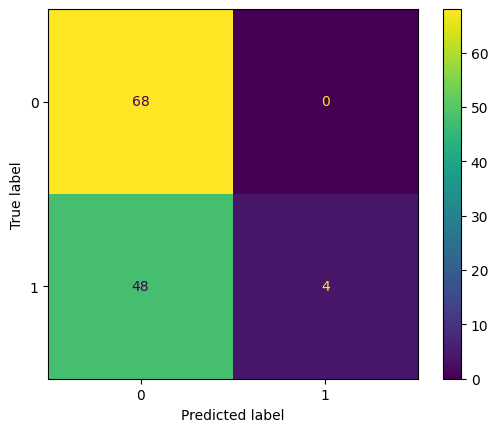

In [4]:
model = run_nets(days_ahead, 100)

/workspaces/OEOD-/SUP/utilis.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df[indicators.columns] = scaler_indicators.transform(indicators)
/workspaces/OEOD-/SUP/utilis.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  read_df[indicators.columns] = scaler_indicators.transform(indicators)
/workspaces/OEOD-/SUP/utilis.py:246: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 108, 128)          66560     
                                                                 
 lstm_19 (LSTM)              (None, 108, 64)           49408     
                                                                 
 dense_18 (Dense)            (None, 108, 64)           4160      
                                                                 
 dropout_12 (Dropout)        (None, 108, 64)           0         
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dropout_13 (Dropout)        (None, 32)               

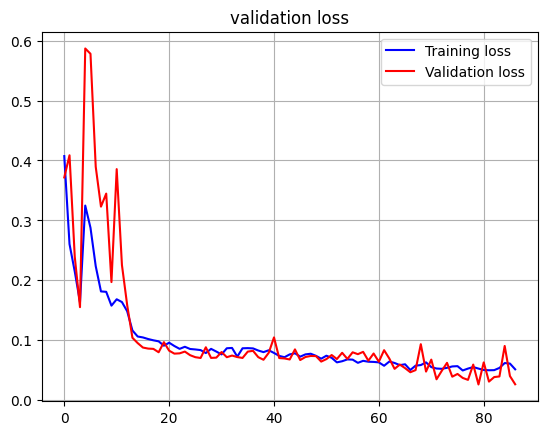

Evaluate model on test data
4/4 [==============================] - 1s 42ms/step
--------------------------------------------------------
test MAPE: 2.9192166741130414 %
-------------------------------------------------------
Trend Catch Accuracy: 65.83333333333333 %


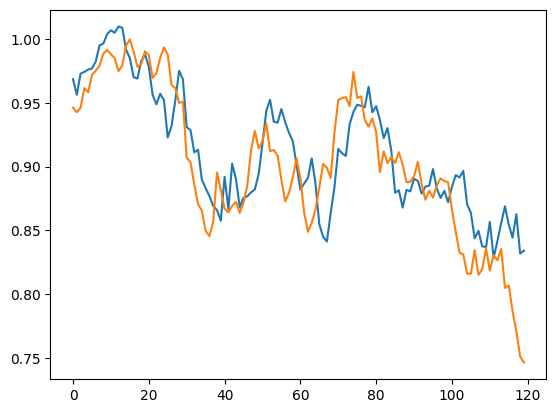

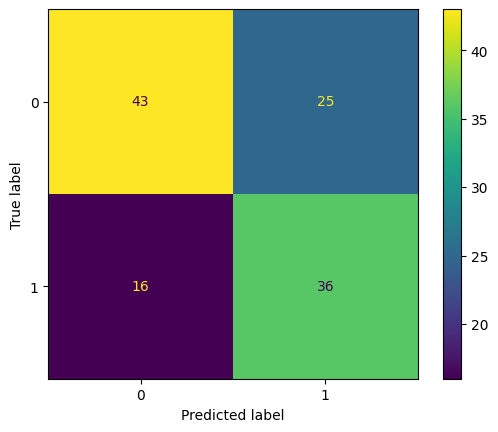

In [8]:
model_200 = run_nets(days_ahead, 75)


In [6]:
model_200

In [10]:
model_200.save('model_75.keras')
